In [17]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns


In [18]:
def calc_exp_qty(n, agg=True):
    '''Calculate the quantity of exported hydrogen in TWh'''
    q = n.snapshot_weightings.generators @ n.links_t.p0.filter(like="export")
    if agg:
        q = q.sum()
    return q / 1e6

def calc_elec_price(n):
    elec_mps = n.buses_t.marginal_price.filter(regex="AC$")
    elec_demand = n.loads_t.p.filter(regex="EV$|AC$")
    elec_demand.columns = elec_demand.columns.str.split(" ").str[0]
    elec_demand = elec_demand.groupby(elec_demand.columns, axis=1).sum()
    elec_costs = (elec_mps*elec_demand).sum().sum()
    return  elec_costs / elec_demand.sum().sum(), elec_costs/1e9

In [19]:
# Define the path to the networks
path = "/home/cpschau/Code/dev/BRIGHT/submodules/pypsa-earth-sec/results/241115_ir_sensitivity/postnetworks"

# Initialize an empty DataFrame
df = pd.DataFrame(columns=["scenario", "mp_EUR_per_MWh", "ecc", "ir", "exp_qty_TWh", "total_cost_bnEUR", "elec_price_EUR_per_MWh", "elec_costs_bnEUR"])

# Parse the networks and fill the DataFrame
for f in os.listdir(path):
    if f.endswith("ecc.nc"):
        scenario = f.split("_")[-4]
        mp = f.split("_")[-2].strip("mp")
        ecc = f.split("_")[-1].strip("ecc.nc")
        ir = f.split("_")[-5]
        n = pypsa.Network(f"{path}/{f}")
        
        # Calculate the necessary variables
        exp_qty_TWh = calc_exp_qty(n)  # Replace with the actual function to calculate exported hydrogen quantity
        total_cost_bnEUR = n.objective / 1e9
        if total_cost_bnEUR < 0:
            breakpoint()
        elec_price_EUR_per_MWh, elec_costs_bnEUR = calc_elec_price(n)  # Replace with the actual function to calculate electricity price and costs
        
        # Append the data to the DataFrame
        new_row = pd.DataFrame([{
            "scenario": scenario,
            "mp_EUR_per_MWh": mp,
            "ir": ir,
            "ecc": ecc,
            "exp_qty_TWh": exp_qty_TWh,
            "total_cost_bnEUR": total_cost_bnEUR,
            "elec_price_EUR_per_MWh": elec_price_EUR_per_MWh,
            "elec_costs_bnEUR": elec_costs_bnEUR
        }])
        df = pd.concat([df, new_row], ignore_index=True)

# Drop rows with GH scenario & 0.12 interest rate & 1 ecc
df = df.drop(df[(df["scenario"] == "GH") & (df["ir"] == "0.12") & (df["ecc"] == "1")].index)

# Function to check if reference system exists
def reference_system_exists(row):
    return not df[(df["scenario"] == row["scenario"]) & 
                  (df["mp_EUR_per_MWh"] == "endogenous") & 
                  (df["ecc"] == row["ecc"]) & 
                  (df["ir"] == row["ir"])].empty

# Filter rows where reference system exists
df = df[df.apply(reference_system_exists, axis=1)]

# Calculate system savings and electricity savings dependent variables
df["system_savings_bnEUR"] = df.apply(lambda x: max(df[(df["scenario"] == x["scenario"]) & (df["mp_EUR_per_MWh"] == "endogenous") & (df["ecc"] == x["ecc"]) & (df["ir"] == x["ir"])]["total_cost_bnEUR"].values[0] - x["total_cost_bnEUR"], 0), axis=1)
df["system_savings_EUR_per_TWh"] = df.apply(lambda x: max(x["system_savings_bnEUR"] / x["exp_qty_TWh"] * 1e9, 0) if x["exp_qty_TWh"] != 0 else 0, axis=1)

df["elec_savings_bnEUR"] = df.apply(lambda x: max(df[(df["scenario"] == x["scenario"]) & (df["mp_EUR_per_MWh"] == "endogenous") & (df["ecc"] == x["ecc"]) & (df["ir"] == x["ir"])]["elec_costs_bnEUR"].values[0] - x["elec_costs_bnEUR"], 0), axis=1)
df["elec_savings_EUR_per_TWh"] = df.apply(lambda x: max(x["elec_savings_bnEUR"] / x["exp_qty_TWh"] * 1e9, 0) if x["exp_qty_TWh"] != 0 else 0, axis=1)

df["ir"] = df["ir"].astype(float)
df["ecc"] = df["ecc"].astype(float)
# Cast mp to int if possible
df["mp_EUR_per_MWh"] = df["mp_EUR_per_MWh"].astype(int, errors="ignore")
df.set_index(["scenario", "mp_EUR_per_MWh", "ecc", "ir"], inplace=True)
df = df.sort_index(ascending=True).sort_index(axis=1, ascending=True).reset_index()

/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Va

In [20]:
df#query("exp_qty_TWh == '0'")

,scenario,mp_EUR_per_MWh,ecc,ir,elec_costs_bnEUR,elec_price_EUR_per_MWh,elec_savings_EUR_per_TWh,elec_savings_bnEUR,exp_qty_TWh,system_savings_EUR_per_TWh,system_savings_bnEUR,total_cost_bnEUR
0,BI,30,1.0,0.06,0.011331,0.152143,8.773490e+04,0.036963,421.297727,9.009054e+05,0.379549,95.678398
1,BI,30,1.0,0.08,0.010471,0.140594,5.199450e+11,0.044510,0.000086,1.374004e+12,0.117623,97.415216
2,BI,40,1.0,0.06,0.025242,0.338918,2.432454e+04,0.023052,947.674767,7.987461e+06,7.569515,88.488433
3,BI,40,1.0,0.08,0.028723,0.385652,3.311443e+04,0.026259,792.972015,5.406546e+06,4.287240,93.245599
4,BI,50,1.0,0.06,0.081401,1.092945,0.000000e+00,0.000000,1480.629432,1.410885e+07,20.889982,75.167966
5,BI,50,1.0,0.08,0.037082,0.497883,1.370105e+04,0.017900,1306.466947,1.147338e+07,14.989593,82.543245
6,BI,60,1.0,0.06,0.142800,1.917334,0.000000e+00,0.000000,1626.949224,2.230642e+07,36.291414,59.766534
7,BI,60,1.0,0.08,0.106296,1.427200,0.000000e+00,0.000000,1503.721679,1.956716e+07,29.423561,68.109277
8,BI,endogenous,1.0,0.06,0.048294,0.648427,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,96.057948
9,BI,endogenous,1.0,0.08,0.054982,0.738220,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,97.532838


In [21]:
#drop df entries where mp_EUR_per_MWh % 10 is not 0 for numeric values or mp_EUR_per_MWH is not endogenous for string values





In [22]:
df.sort_values("total_cost_bnEUR")

,scenario,mp_EUR_per_MWh,ecc,ir,elec_costs_bnEUR,elec_price_EUR_per_MWh,elec_savings_EUR_per_TWh,elec_savings_bnEUR,exp_qty_TWh,system_savings_EUR_per_TWh,system_savings_bnEUR,total_cost_bnEUR
6,BI,60,1.0,0.06,0.142800,1.917334,0.000000e+00,0.000000,1626.949224,2.230642e+07,36.291414,59.766534
11,GH,50,1.0,0.06,0.075720,1.076782,0.000000e+00,0.000000,1420.058060,1.370841e+07,19.466736,67.985693
7,BI,60,1.0,0.08,0.106296,1.427200,0.000000e+00,0.000000,1503.721679,1.956716e+07,29.423561,68.109277
4,BI,50,1.0,0.06,0.081401,1.092945,0.000000e+00,0.000000,1480.629432,1.410885e+07,20.889982,75.167966
10,DE,endogenous,1.0,0.06,0.050519,0.558493,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,82.429608
5,BI,50,1.0,0.08,0.037082,0.497883,1.370105e+04,0.017900,1306.466947,1.147338e+07,14.989593,82.543245
12,GH,endogenous,1.0,0.06,0.069296,0.985435,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,87.452429
2,BI,40,1.0,0.06,0.025242,0.338918,2.432454e+04,0.023052,947.674767,7.987461e+06,7.569515,88.488433
3,BI,40,1.0,0.08,0.028723,0.385652,3.311443e+04,0.026259,792.972015,5.406546e+06,4.287240,93.245599
0,BI,30,1.0,0.06,0.011331,0.152143,8.773490e+04,0.036963,421.297727,9.009054e+05,0.379549,95.678398


/tmp/ipykernel_133889/1549884946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy["mp_EUR_per_MWh"] = df_copy["mp_EUR_per_MWh"].astype(float)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

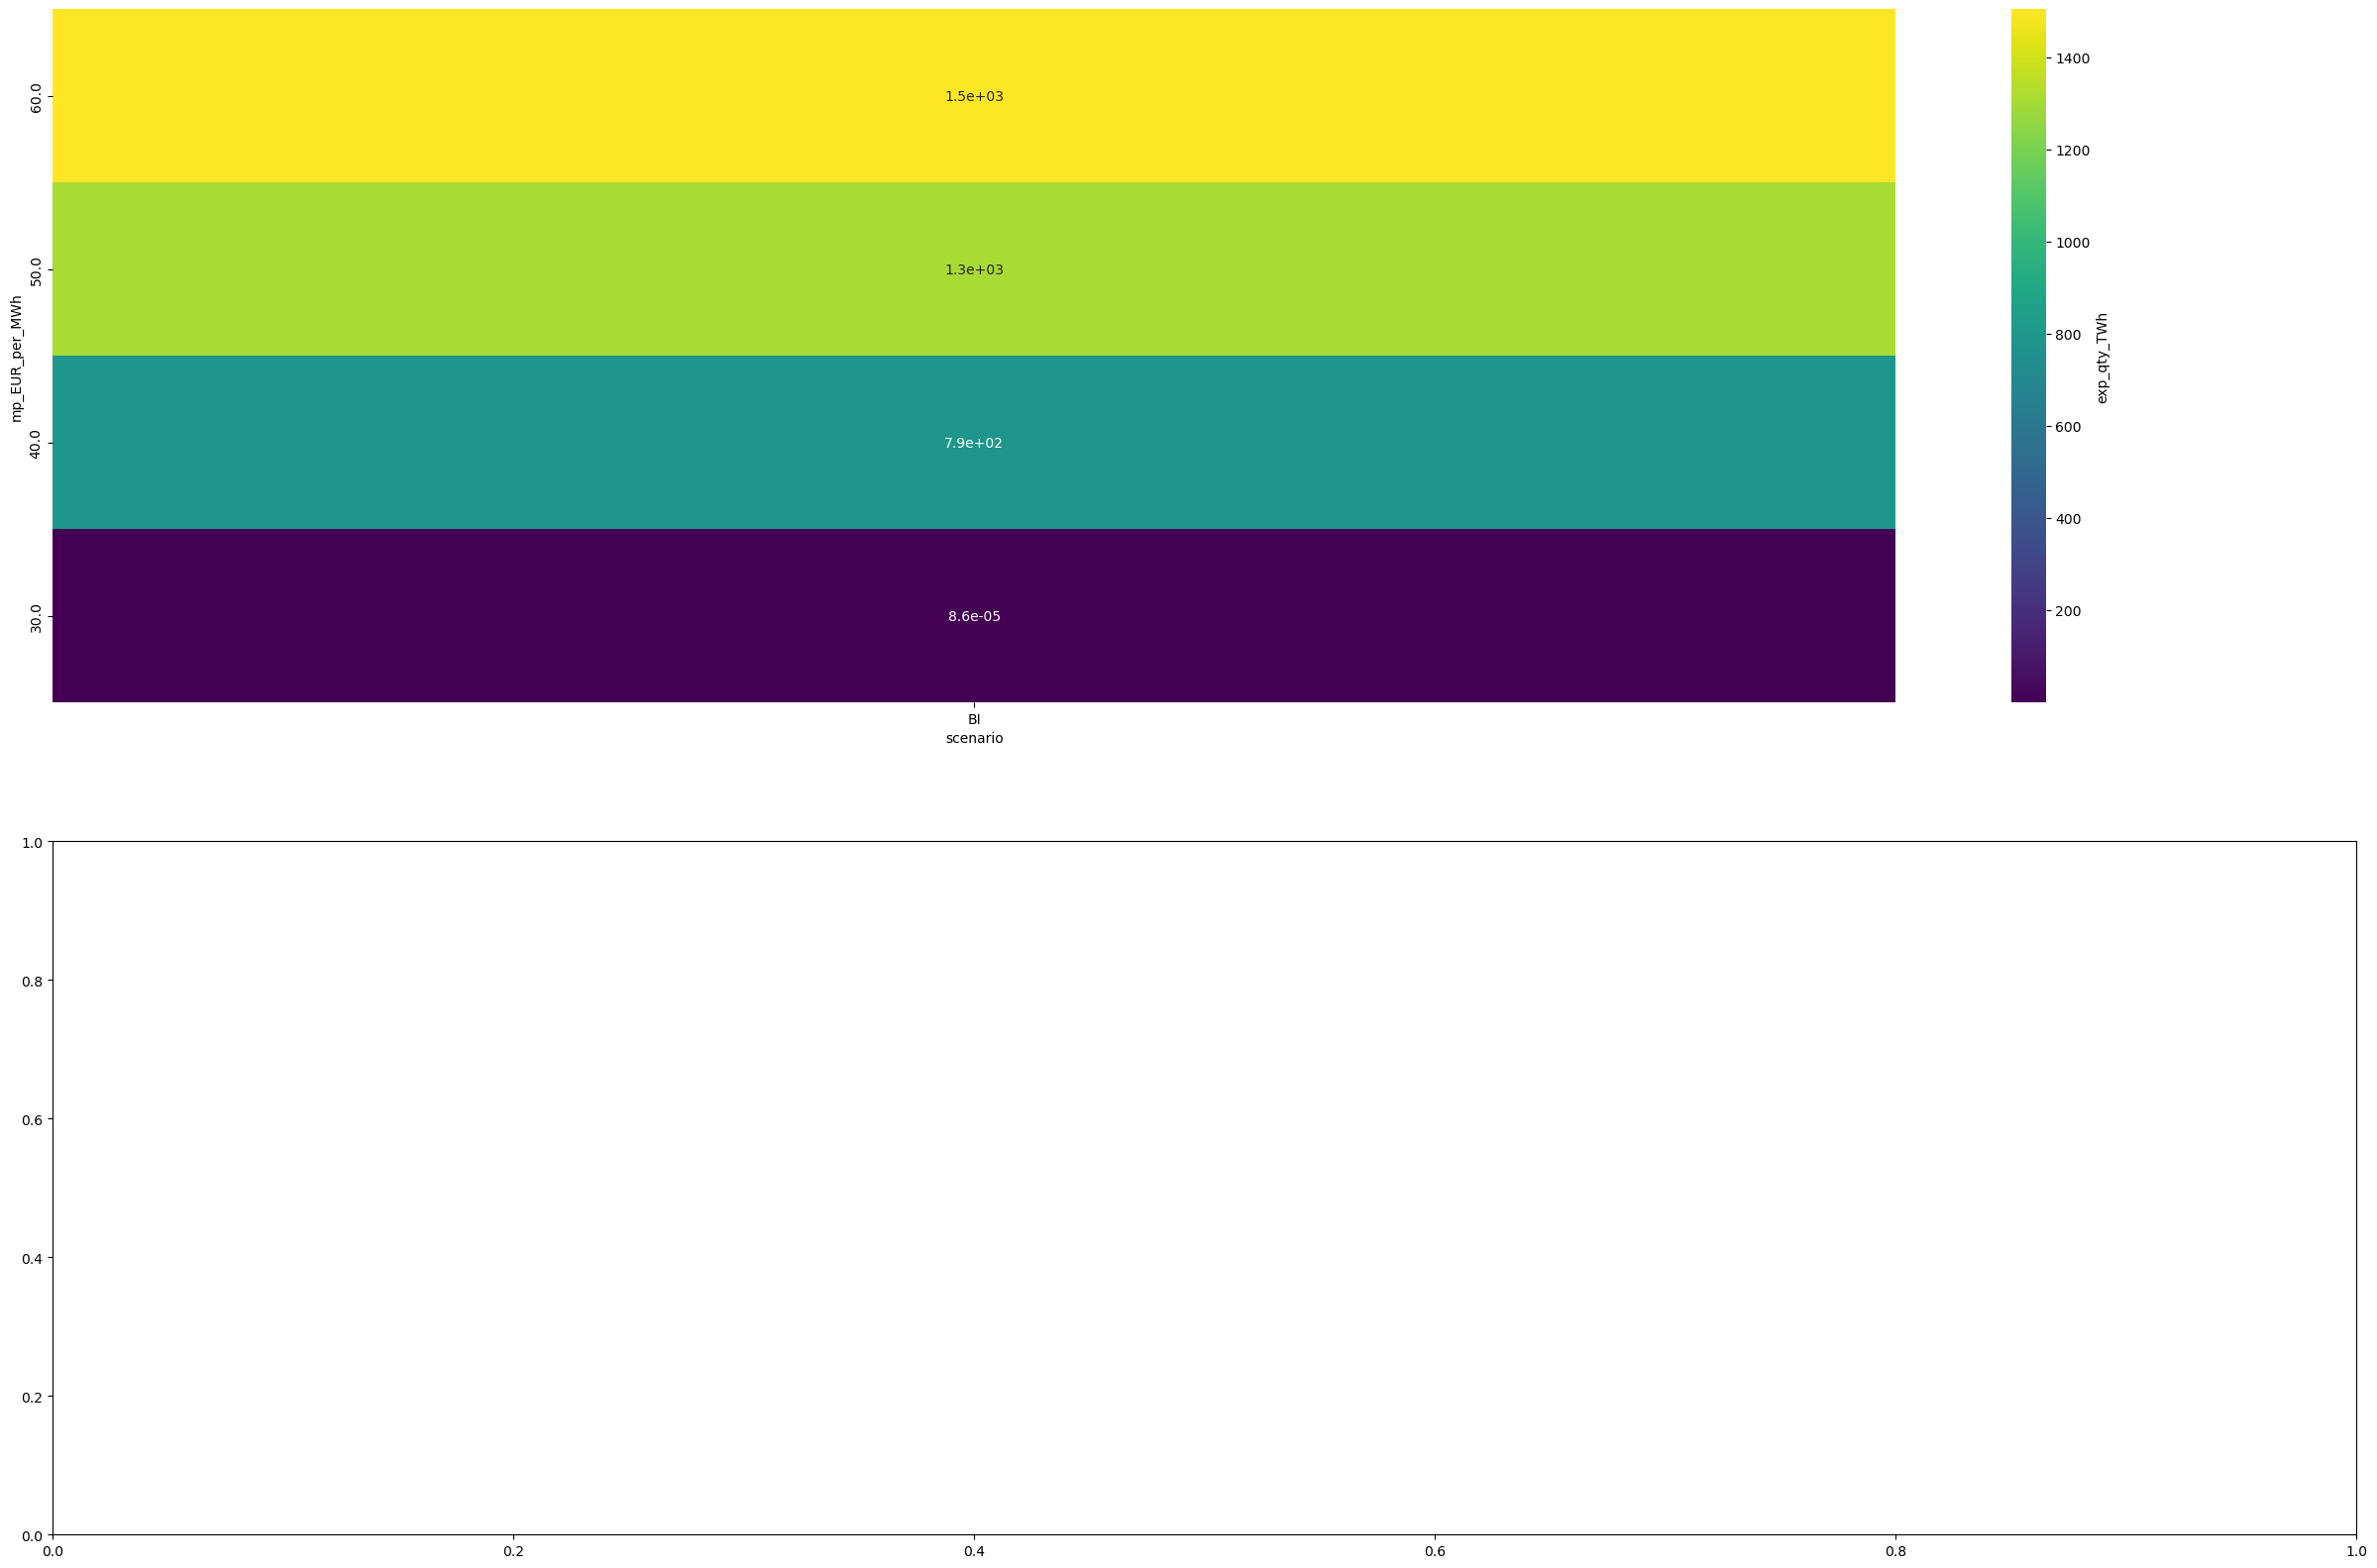

In [ ]:
variables = ["exp_qty_TWh", "total_cost_bnEUR"]#, "system_savings_bnEUR", "system_savings_EUR_per_TWh", "elec_price_EUR_per_MWh", "elec_savings_bnEUR"]

df_copy = df.query("mp_EUR_per_MWh != 'endogenous' and ecc == 1.0 and scenario == 'BI' and ir == 0.08")
df_copy["mp_EUR_per_MWh"] = df_copy["mp_EUR_per_MWh"].astype(float)
#df_copy = df_copy.loc[(df_copy['mp_EUR_per_MWh'] <= 90) & (df_copy['mp_EUR_per_MWh'] >= 75)]

scenarios = df_copy["scenario"].unique()

fig, axs = plt.subplots(len(variables), len(df_copy['ir'].unique()), figsize=(30, 20))

for i, variable in enumerate(variables):
    vmin = df_copy[variable].min()
    vmax = df_copy[variable].max()
    
    for j, ir in enumerate(df_copy['ir'].unique()):
        pivot_table = df_copy[df_copy["ir"] == ir].pivot(index="mp_EUR_per_MWh", columns="scenario", values=variable)
        pivot_table = pivot_table.sort_index(ascending=False).sort_index(axis=1, ascending=False)
        if len(df_copy['ir'].unique()) == 1:
            sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': variable}, ax=axs[i], vmin=vmin, vmax=vmax)
            axs[i].set_title(f"{variable}\n{df_copy.ecc.values[0]} * 1350 €/kW\nElectrolysis CAPEX\nInterest rate: {ir}")
            axs[i].set_xlabel("Scenario")
            axs[i].set_ylabel("Global Hydrogen\nMarket Price (€/MWh)")
        else:
            sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': variable}, ax=axs[i, j], vmin=vmin, vmax=vmax)
            axs[i, j].set_title(f"{variable}\n{df_copy.ecc.values[0]} * 1350 €/kW\nElectrolysis CAPEX\nInterest rate: {ir}")
            axs[i, j].set_xlabel("Scenario")
            axs[i, j].set_ylabel("Global Hydrogen\nMarket Price (€/MWh)")

plt.tight_layout()
plt.show()

/tmp/ipykernel_133889/2926664420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy["mp_EUR_per_MWh"] = df_copy["mp_EUR_per_MWh"].astype(float)


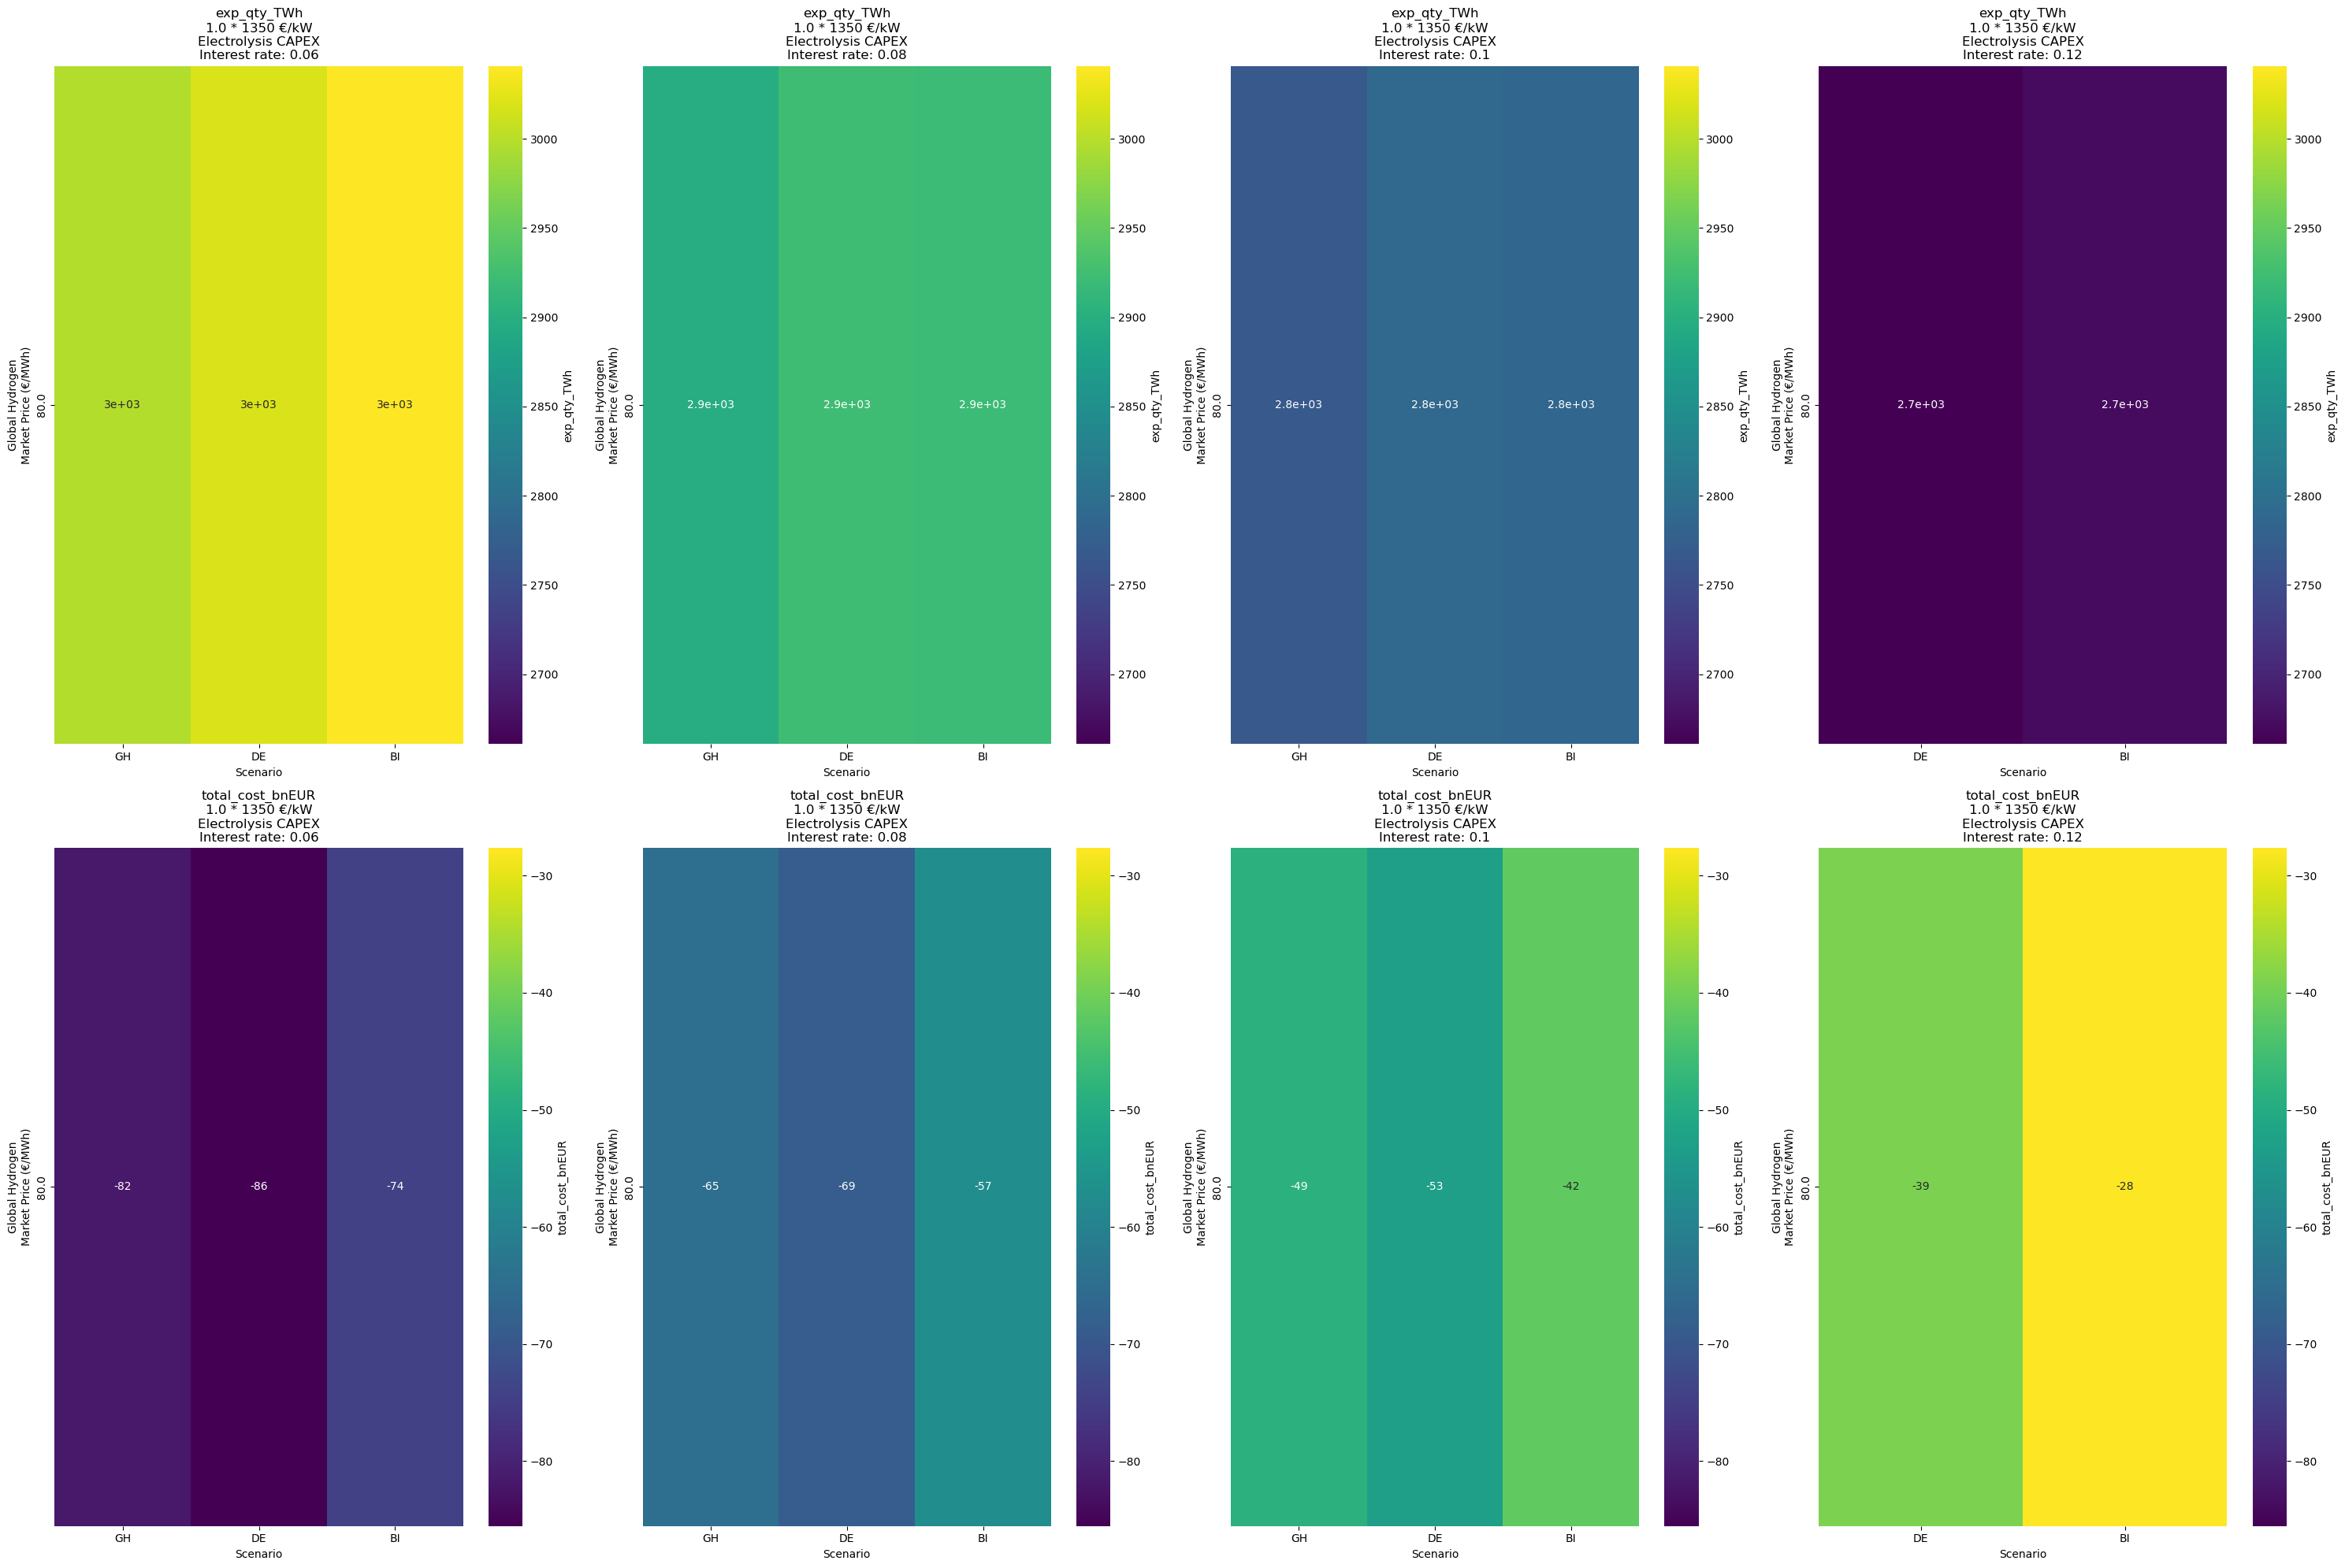

In [ ]:
variables = ["exp_qty_TWh", "total_cost_bnEUR"]#, "system_savings_bnEUR", "system_savings_EUR_per_TWh", "elec_price_EUR_per_MWh", "elec_savings_bnEUR"]

df_copy = df.query("mp_EUR_per_MWh != 'endogenous' and ecc == 1")
df_copy["mp_EUR_per_MWh"] = df_copy["mp_EUR_per_MWh"].astype(float)
#df_copy = df_copy.loc[(df_copy['mp_EUR_per_MWh'] <= 90) & (df_copy['mp_EUR_per_MWh'] >= 75)]

scenarios = df_copy["scenario"].unique()

fig, axs = plt.subplots(len(variables), len(df_copy['ir'].unique()), figsize=(30, 20))

for i, variable in enumerate(variables):
    vmin = df_copy[variable].min()
    vmax = df_copy[variable].max()
    
    for j, ir in enumerate(df_copy['ir'].unique()):
        pivot_table = df_copy[df_copy["ir"] == ir].pivot(index="mp_EUR_per_MWh", columns="scenario", values=variable)
        pivot_table = pivot_table.sort_index(ascending=False).sort_index(axis=1, ascending=False)
        sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': variable}, ax=axs[i, j], vmin=vmin, vmax=vmax)
        axs[i, j].set_title(f"{variable}\n{df_copy.ecc.values[0]} * 1350 €/kW\nElectrolysis CAPEX\nInterest rate: {ir}")
        axs[i, j].set_xlabel("Scenario")
        axs[i, j].set_ylabel("Global Hydrogen\nMarket Price (€/MWh)")

plt.tight_layout()
plt.show()

In [ ]:
n = pypsa.Network("/home/cpschau/Code/dev/BRIGHT/submodules/pypsa-earth-sec/results/241107_ir_sensitivity/postnetworks/elec_s_11_ec_lv1.0_Co2L_3H_2035_0.1_BI_0export_endogenousmp_1ecc.nc")

/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Va

In [ ]:
n.generators.filter(regex="solar$", axis=0).p_nom.sum()

37449.20500000001

In [ ]:
n1 = pypsa.Network("/home/cpschau/Code/dev/BRIGHT/submodules/pypsa-earth-sec/pypsa-earth/networks/elec_s_11_ec_lv2.0_Co2L.nc")

/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/home/cpschau/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Va

In [ ]:
n1.generators.filter(regex="solar$", axis=0).p_nom.sum()

37449.20500000001

/tmp/ipykernel_133889/273405371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["mp_EUR_per_MWh"] = df["mp_EUR_per_MWh"].astype(float)


ValueError: Index contains duplicate entries, cannot reshape

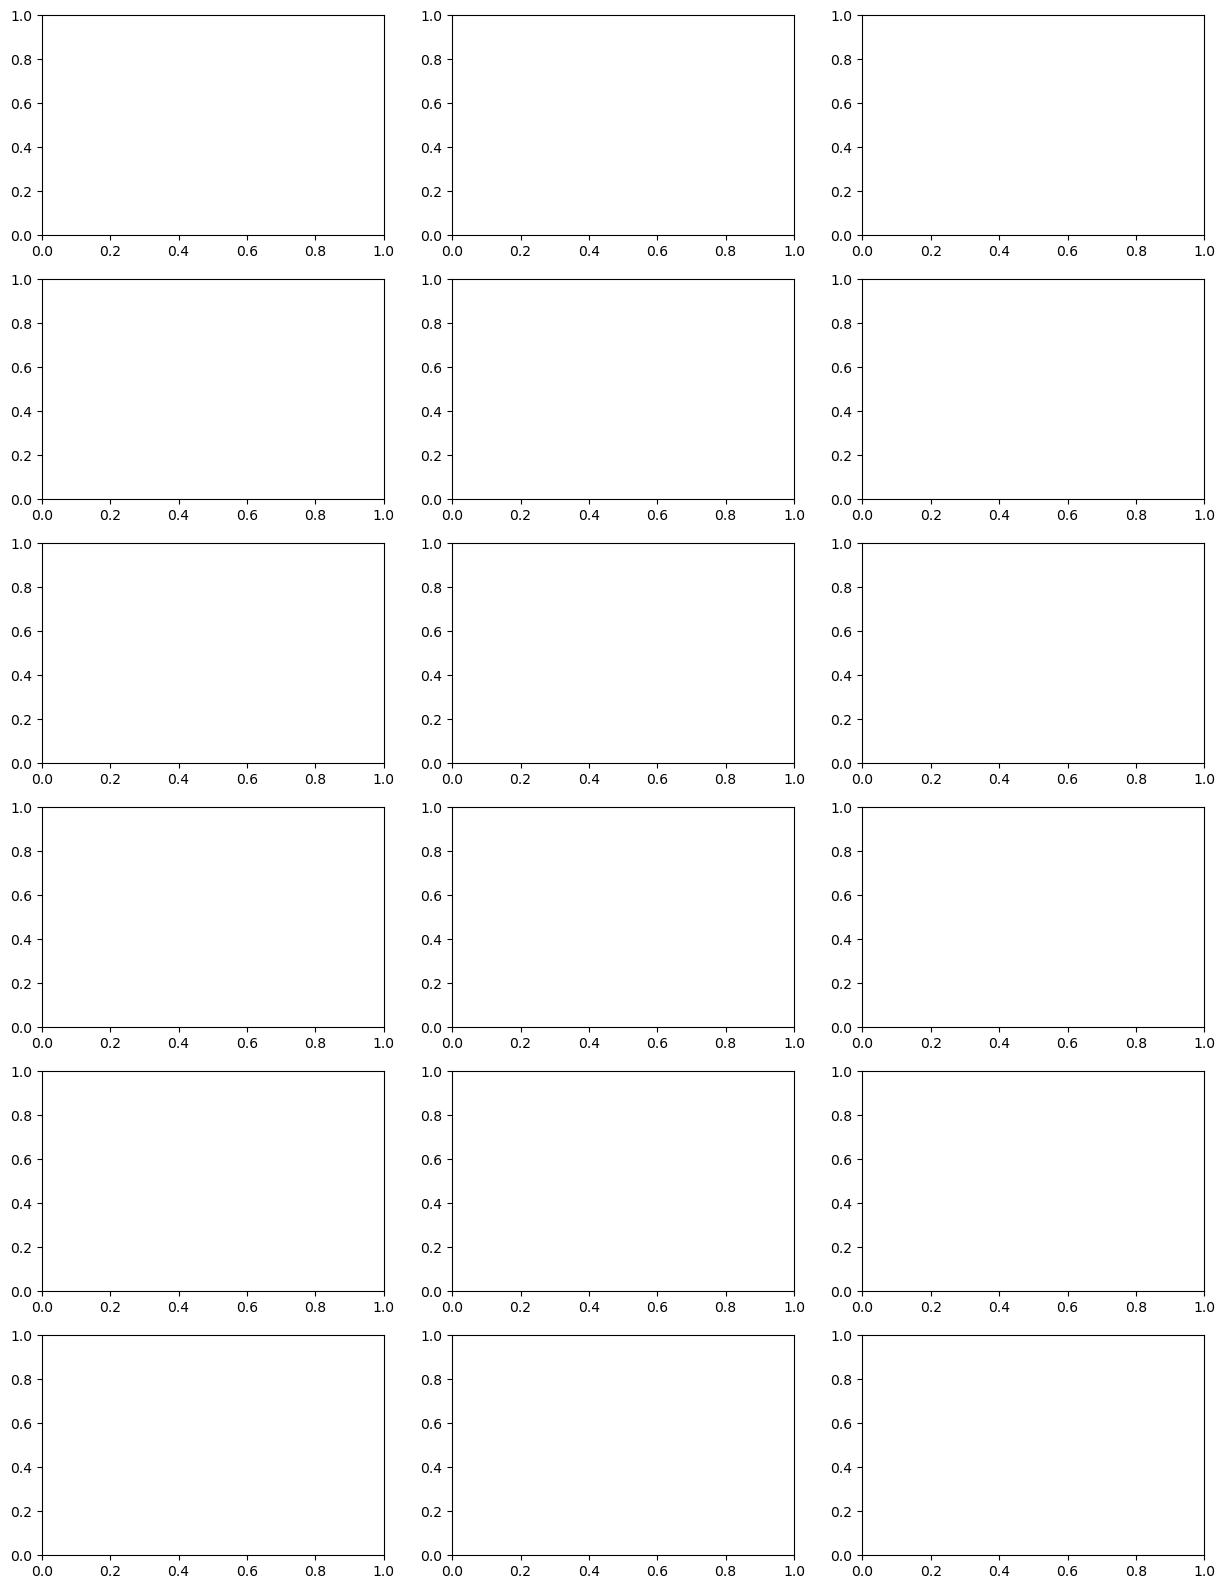

In [ ]:
variables = ["exp_qty_TWh", "total_cost_bnEUR", "system_savings_bnEUR", "system_savings_EUR_per_TWh", "elec_price_EUR_per_MWh", "elec_savings_bnEUR"]
df = df.loc[df['mp_EUR_per_MWh'] != 'endogenous']
df["mp_EUR_per_MWh"] = df["mp_EUR_per_MWh"].astype(float)
df = df.loc[(df['mp_EUR_per_MWh'] <= 90) & (df['mp_EUR_per_MWh'] >= 75)]

scenarios = df["scenario"].unique()

fig, axs = plt.subplots(len(variables), len(scenarios), figsize=(15, 20))

for i, variable in enumerate(variables):
    vmin = df[variable].min()
    vmax = df[variable].max()
    
    for j, scenario in enumerate(scenarios):
        pivot_table = df[df["scenario"] == scenario].pivot(index="ecc", columns="mp_EUR_per_MWh", values=variable)
        pivot_table = pivot_table.sort_index(ascending=False).sort_index(axis=1, ascending=False)
        sns.heatmap(pivot_table, annot=True, cmap="viridis", cbar_kws={'label': variable}, ax=axs[i, j], vmin=vmin, vmax=vmax)
        axs[i, j].set_title(f"{scenario} - {variable}")
        axs[i, j].set_xlabel("Global Hydrogen\nMarket Price (€/MWh)")
        axs[i, j].set_ylabel("Electrolyzer CAPEX\n(800 €/kW * factor)")

plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("bright_sensitivity_analysis_241104.csv", index=False)